In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver
from auto_robot_design.utils.configs import inertial_config_two_link_workspace, inertial_config_two_link_six_trajectories, inertial_config_two_link_six_trajectories_v2, jacobian_config_two_link_workspace, vertical_config_two_link_three_trajectories

In [2]:
builder, crag, soft_constrain, reward_manager = vertical_config_two_link_three_trajectories()

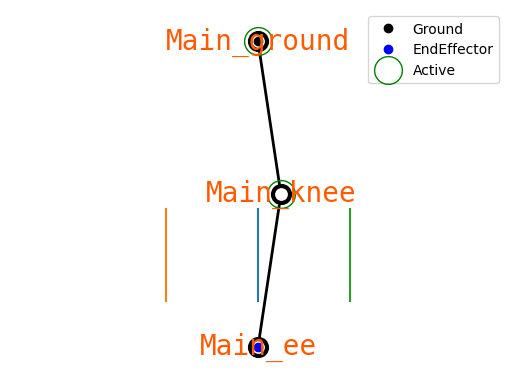

In [3]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[50:, 0], trajectory[50:, 2])
gm = get_preset_by_index_with_bounds(-1)
values = gm.generate_central_from_mutation_range()
graph = gm.get_graph(values)
draw_joint_point(graph)
plt.show("trajectories.png")

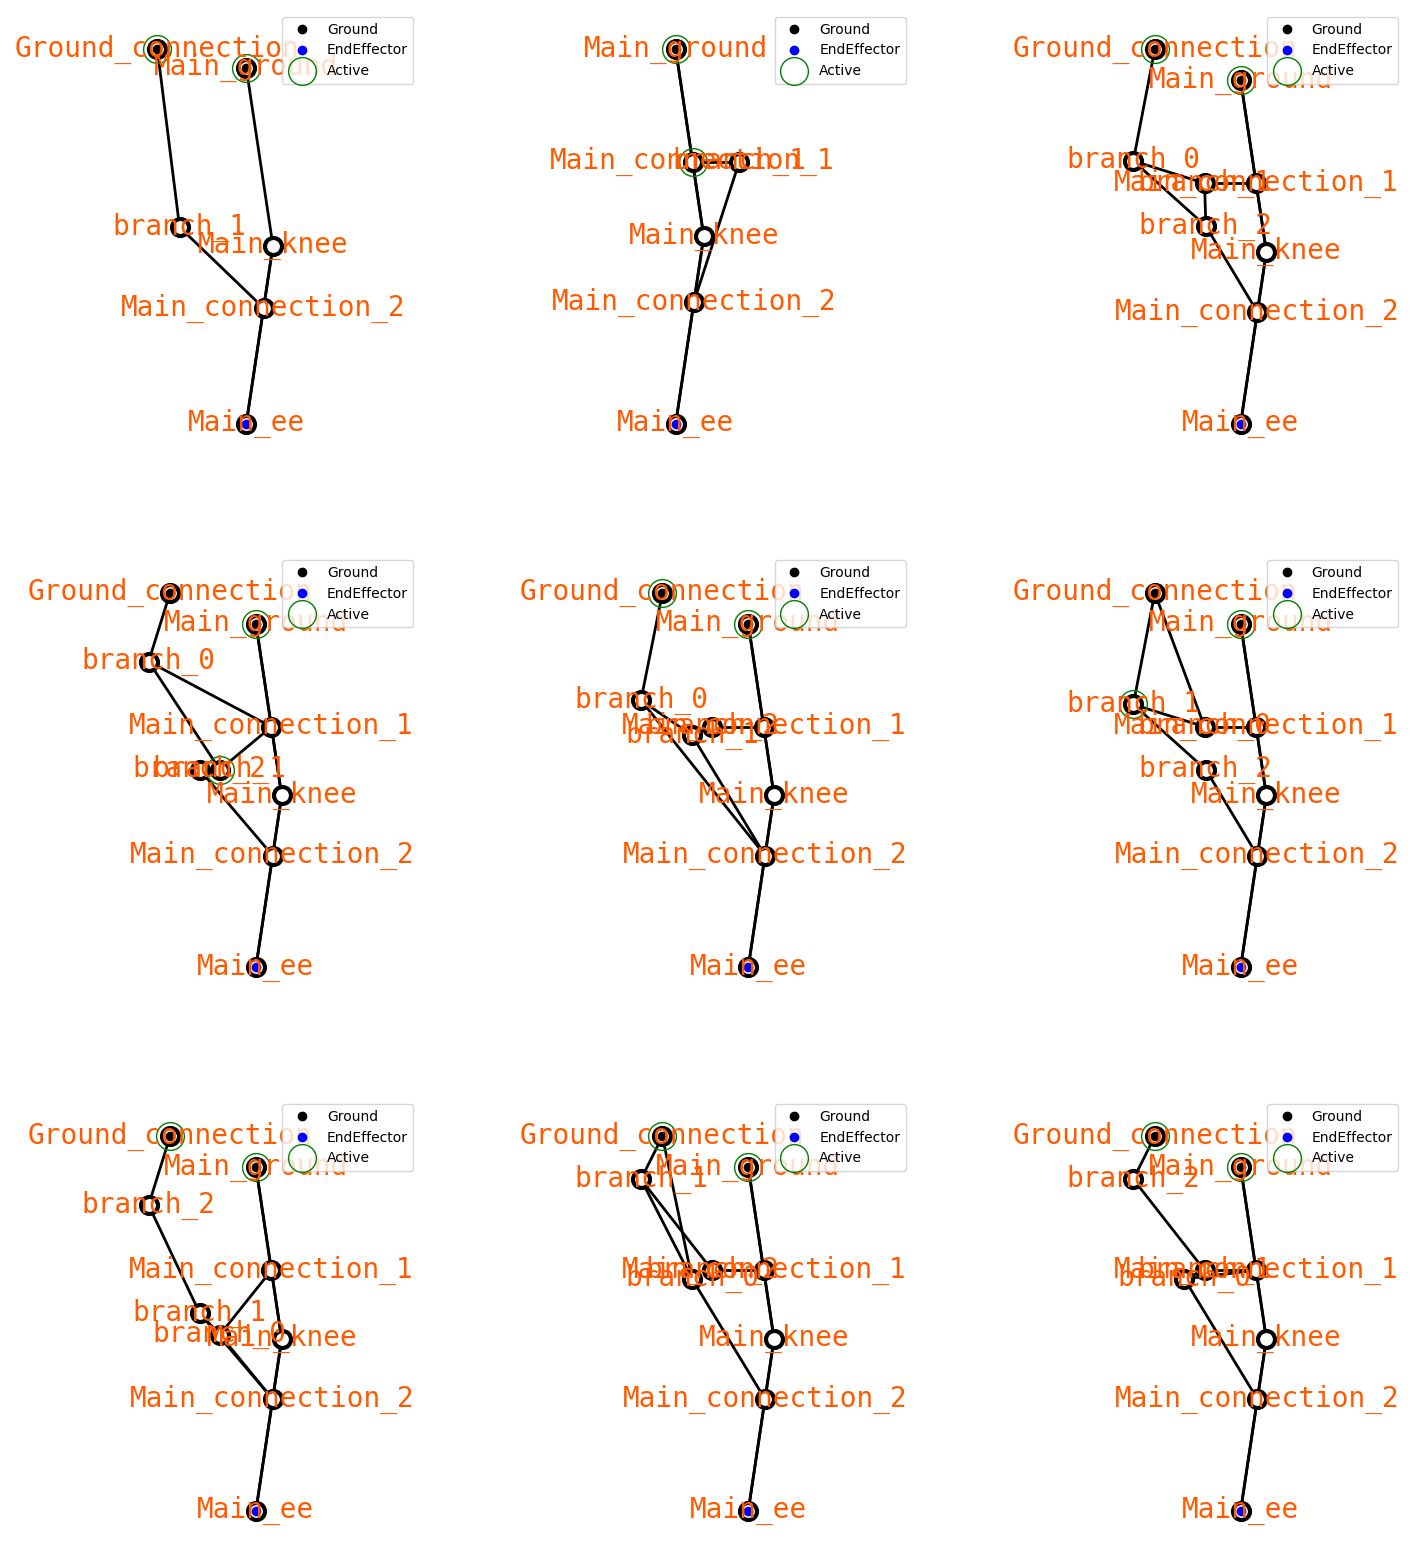

In [4]:
plt.figure(figsize=(18, 20))
for i in range(9):
    gm = get_preset_by_index_with_bounds(i)
    values = gm.generate_central_from_mutation_range()
    graph = gm.get_graph(values)
    plt.subplot(3, 3, i+1)
    draw_joint_point(graph)

plt.show("topologies.png")

In [5]:
pin.seed(1)
N_PROCESS = 8
population_size = 64
n_generations = 100
mechs = [0,2,6,8]
# for i in range(0,9):
for i in mechs:
    pool = multiprocessing.Pool(N_PROCESS)
    runner = StarmapParallelization(pool.starmap)
    topology_index = i
    gm = get_preset_by_index_with_bounds(topology_index)
    # activate multiprocessing

    # create the problem for the current optimization
    problem = MultiCriteriaProblem(gm, builder, reward_manager,
                                soft_constrain, elementwise_runner=runner, Actuator=builder.actuator['default'])

    saver = ProblemSaver(problem, f"imf_mean_hl_vertical\\filtered_topologies_100gen_64pop\\topology_{topology_index}", True)
    saver.save_nonmutable()
    algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
    optimizer = PymooOptimizer(problem, algorithm, saver)

    res = optimizer.run(
        True, **{
            "seed": 2,
            "termination": ("n_gen", n_generations),
            "verbose": True
        })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       64 |      3 |             - |             -
     2 |      128 |     10 |  0.5462491325 |         ideal
     3 |      192 |     17 |  0.0455617679 |             f
     4 |      256 |     21 |  0.0494892077 |         ideal
     5 |      320 |     28 |  0.0294629836 |         ideal
     6 |      384 |     36 |  0.0805842956 |         ideal
     7 |      448 |     42 |  0.0100737236 |             f
     8 |      512 |     55 |  0.0642234798 |         ideal
     9 |      576 |     64 |  0.0155888259 |         ideal
    10 |      640 |     63 |  0.0078243300 |             f
    11 |      704 |     64 |  0.0151471954 |         ideal
    12 |      768 |     64 |  0.0051121581 |             f
    13 |      832 |     64 |  0.0050182759 |             f
    14 |      896 |     64 |  0.0050913135 |             f
    15 |      960 |     64 |  0.0225882740 |         ideal
    16 |     1024 |     64 |  0.0037059228 |            